В данной ячейке я подключаю необходимые библиотеки для работы: pandas и numpy для манипуляций с данными, а также инструменты для визуализации (seaborn, matplotlib). Из библиотеки sklearn импортирую реализацию алгоритма KNN (для классификации и регрессии), необходимые метрики качества и методы предобработки данных (в частности, скейлеры, так как KNN чувствителен к масштабу признаков). Также задаю стиль оформления графиков и отключаю предупреждения для чистоты вывода.

In [1]:
# @title Ячейка 1: Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Настройка стилей для графиков
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


# Лабораторная работа №1: KNN

## 1. Выбор начальных условий

### a. Задача классификации
**Датасет:** Loan Default (Прогнозирование дефолта по кредиту).
**Обоснование:** Это реальная задача банковского скоринга. Банкам критически важно автоматически определять надежность заемщика, чтобы минимизировать финансовые потери. Ошибки 1-го рода (выдача кредита ненадежному) ведут к прямым убыткам, ошибки 2-го рода (отказ надежному) — к упущенной выгоде.

### b. Задача регрессии
**Датасет:** Car Sales (Прогнозирование стоимости автомобиля).
**Обоснование:** Задача актуальна для автодилеров и маркетплейсов. Автоматическая оценка стоимости помогает выставлять конкурентные цены, выкупать авто по рыночной стоимости и выявлять аномальные предложения (мошенничество).

### c. Метрики качества
**Для классификации:**
*   **ROC-AUC:** Основная метрика, так как она устойчива к дисбалансу классов (дефолтов обычно меньше, чем возвратов) и оценивает качество ранжирования вероятностей.
*   **F1-score:** Важен баланс между Precision и Recall.

**Для регрессии:**
*   **R2 (Коэффициент детерминации):** Показывает, какую долю дисперсии цены объясняет модель. Удобен для интерпретации (0..1).
*   **MAE (Mean Absolute Error):** Легко интерпретируется бизнесом ("мы ошибаемся в среднем на 3000 долларов"). Устойчивее к выбросам, чем RMSE.


Загружаю набор данных для задачи классификации (кредитный скоринг). Провожу первичный разведочный анализ (EDA): оцениваю размер выборки, проверяю типы данных (числовые и категориальные) и наличие пропусков с помощью методов .info() и .describe(), чтобы определить стратегию дальнейшей предобработки.

In [2]:
# @title Ячейка 2: Загрузка и анализ датасета для Классификации (Loan Default)
try:
    df_class = pd.read_csv('Loan_Default.csv')
    print("--- Датасет для классификации (Loan Default) загружен ---")
    print(f"Размер датасета: {df_class.shape}")
    display(df_class.head())
    print("\n--- Информация о типах данных и пропусках ---")
    df_class.info()
    print("\n--- Основные статистики ---")
    display(df_class.describe())

    # Проверка баланса классов (предполагаем, что целевая переменная имеет очевидное название, например 'Status' или 'Default')
    # Я попробую найти целевую переменную автоматически или выведу список колонок
    print("\n--- Список колонок ---")
    print(df_class.columns.tolist())

except Exception as e:
    print(f"Ошибка загрузки датасета классификации: {e}")

--- Датасет для классификации (Loan Default) загружен ---
Размер датасета: (148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0



--- Информация о типах данных и пропусках ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-n

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000



--- Список колонок ---
['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']



Загружаю и исследую второй датасет для задачи регрессии (прогнозирование стоимости автомобилей). С помощью методов .info() и .describe() оцениваю качество данных: наличие пропусков, типы признаков и основные статистические показатели распределения (среднее, стандартное отклонение)

In [3]:
# @title Ячейка 3.1: Загрузка и анализ датасета для Регрессии (Car Sales)
try:
    df_reg = pd.read_csv('Car_Sales.csv')
    print("--- Датасет для регрессии (Car Sales) загружен ---")
    print(f"Размер датасета: {df_reg.shape}")
    display(df_reg.head())
    print("\n--- Информация о типах данных и пропусках ---")
    df_reg.info()
    print("\n--- Основные статистики ---")
    display(df_reg.describe())

    print("\n--- Список колонок ---")
    print(df_reg.columns.tolist())

except Exception as e:
    print(f"Ошибка загрузки датасета регрессии: {e}")

--- Датасет для регрессии (Car Sales) загружен ---
Размер датасета: (4345, 9)


,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4



--- Информация о типах данных и пропусках ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB

--- Основные статистики ---


,Price,Mileage,EngineV,Year
count,4173.000000,4345.000000,4195.000000,4345.000000
mean,19418.746935,161.237284,2.790734,2006.550058
std,25584.242620,105.705797,5.066437,6.719097
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,86.000000,1.800000,2003.000000
50%,11500.000000,155.000000,2.200000,2008.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000



--- Список колонок ---
['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Registration', 'Year', 'Model']


--- Распределения числовых признаков: Loan Default ---


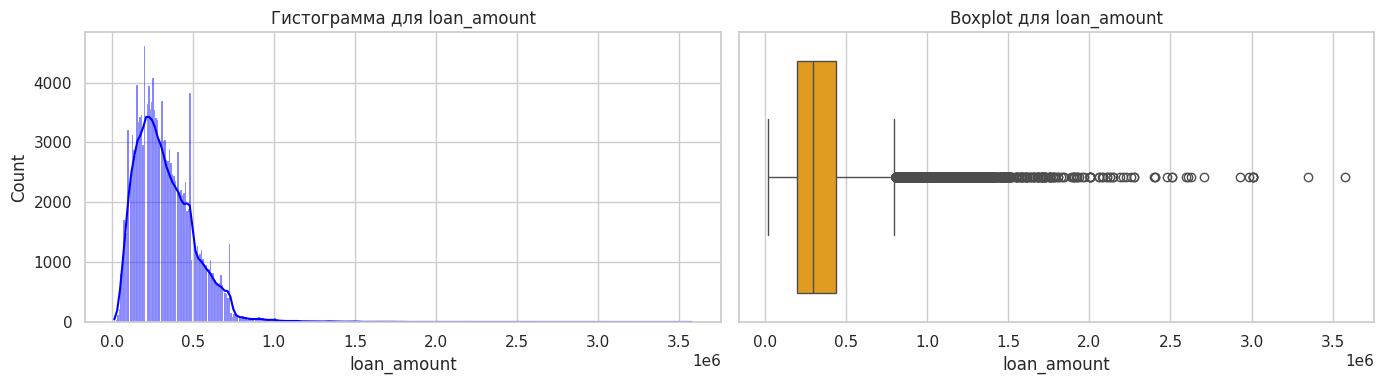

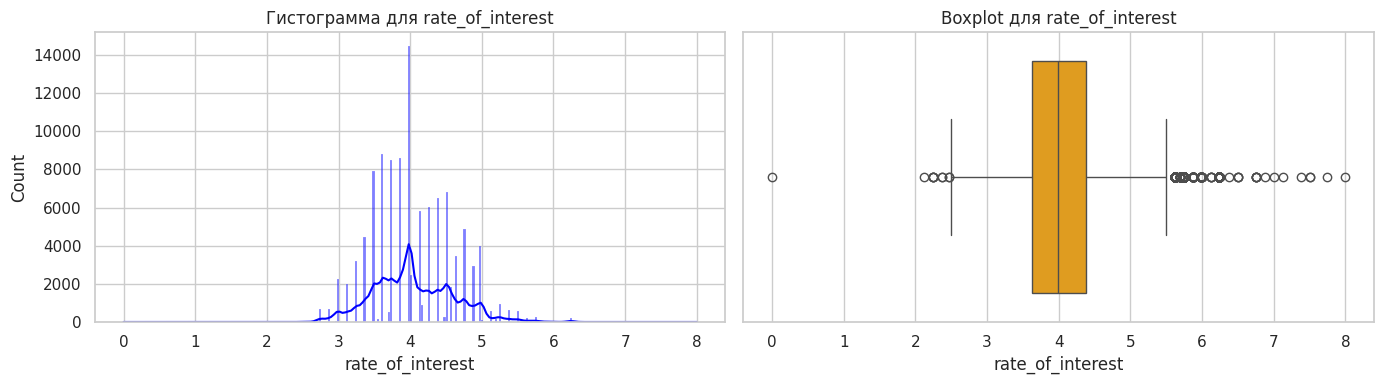

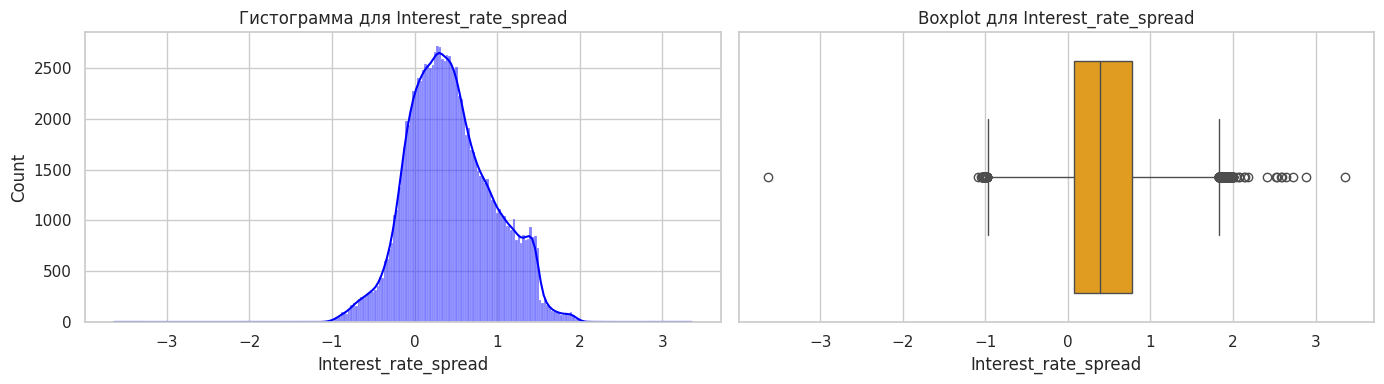

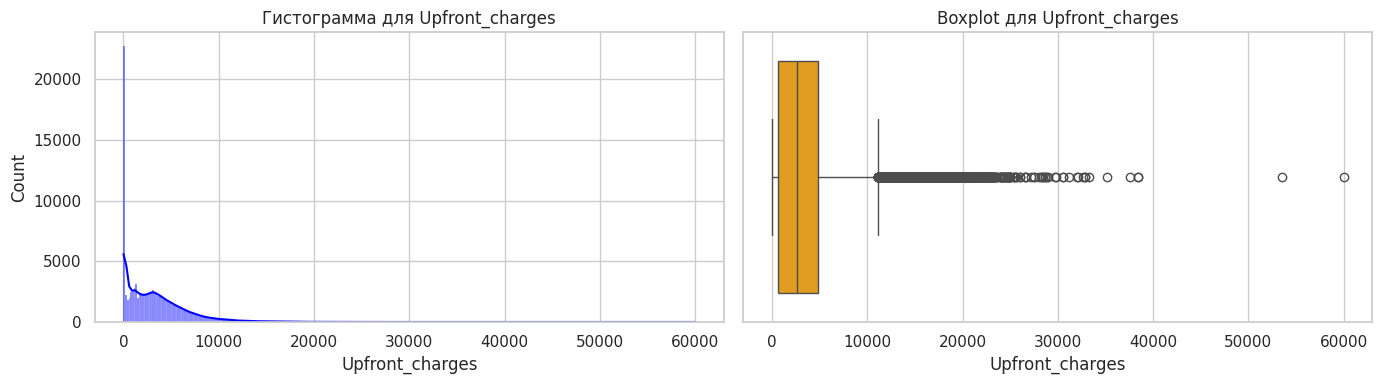

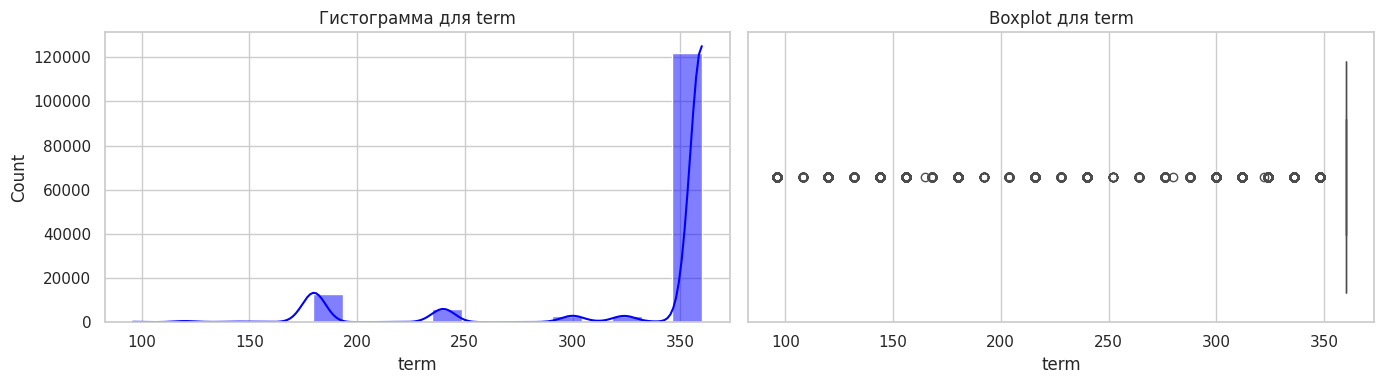

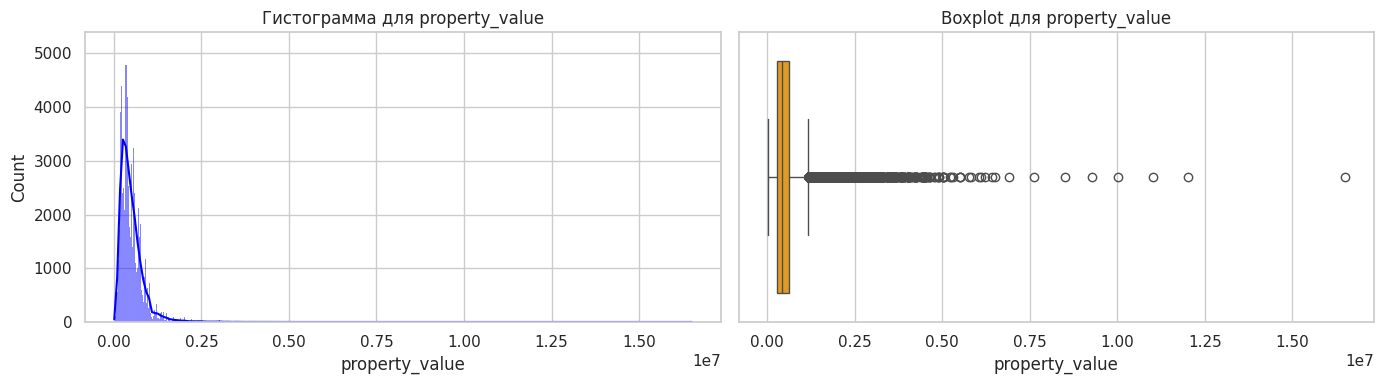

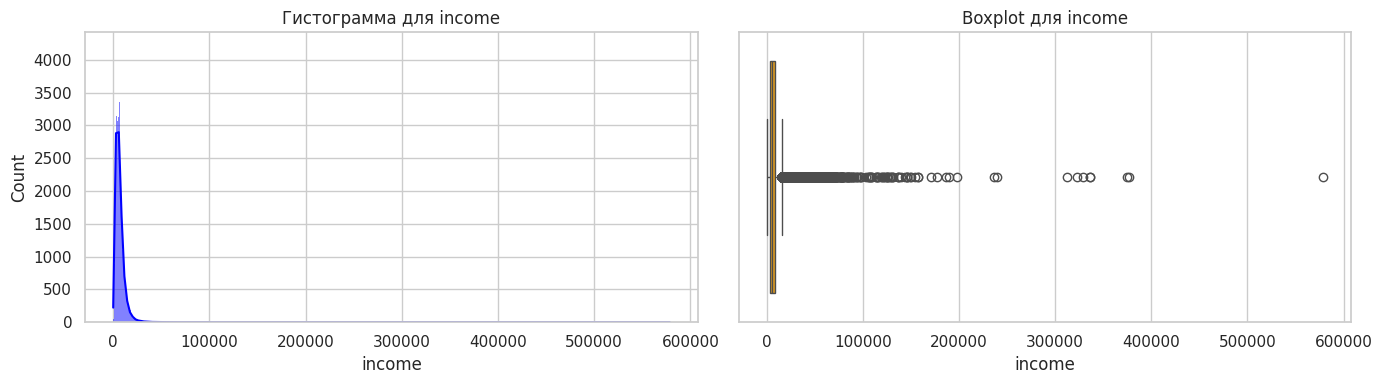

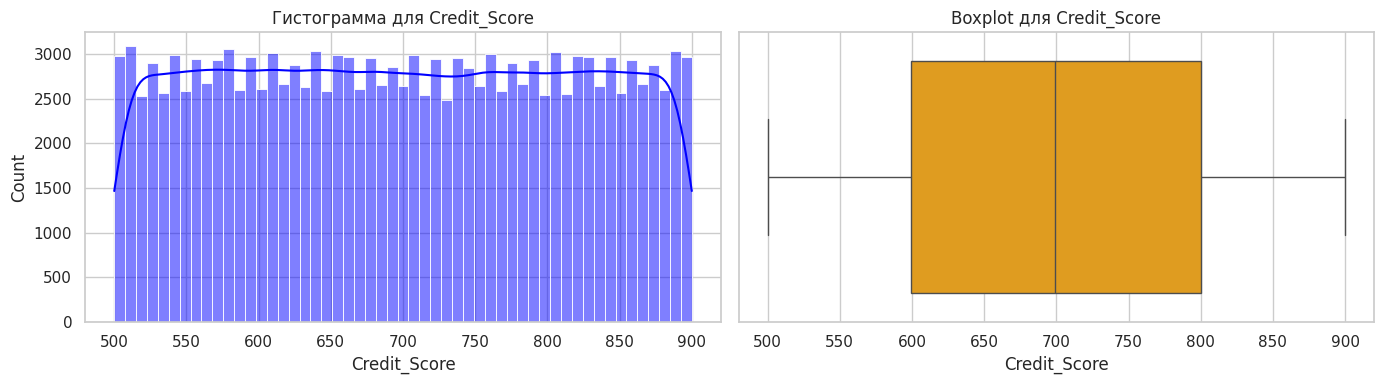

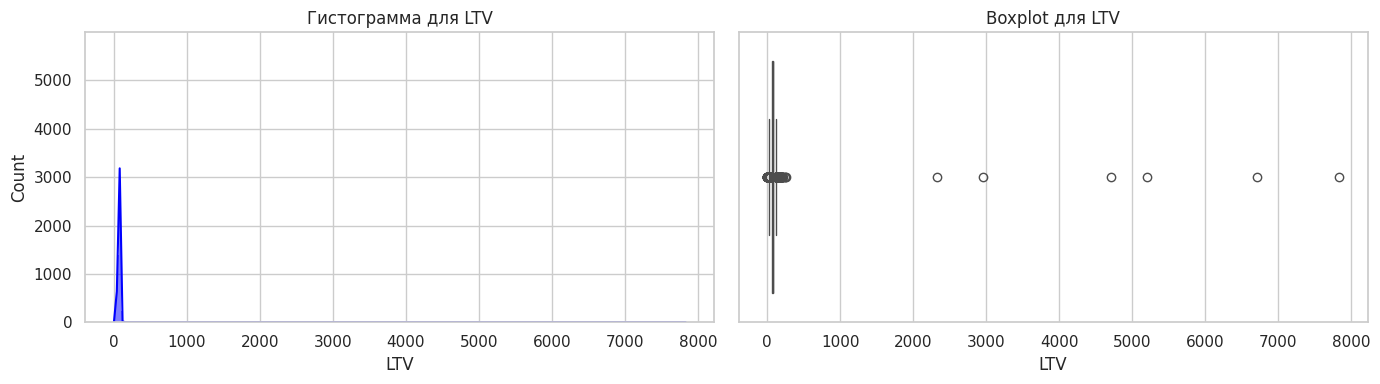

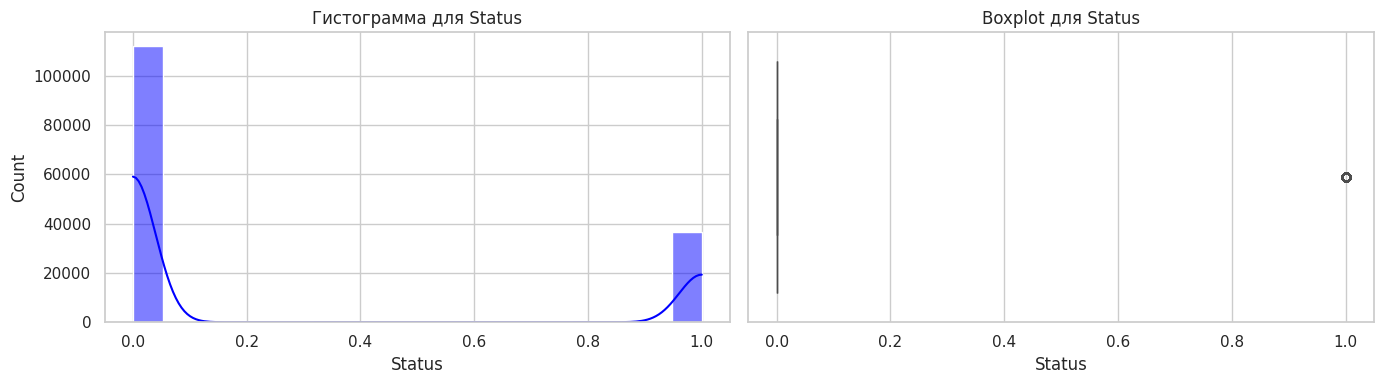

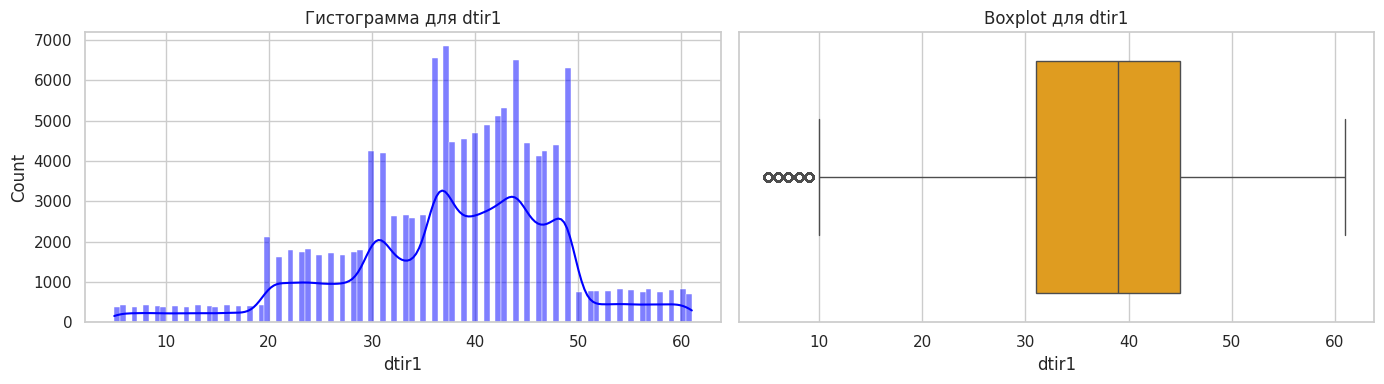

--- Распределения числовых признаков: Car Sales ---


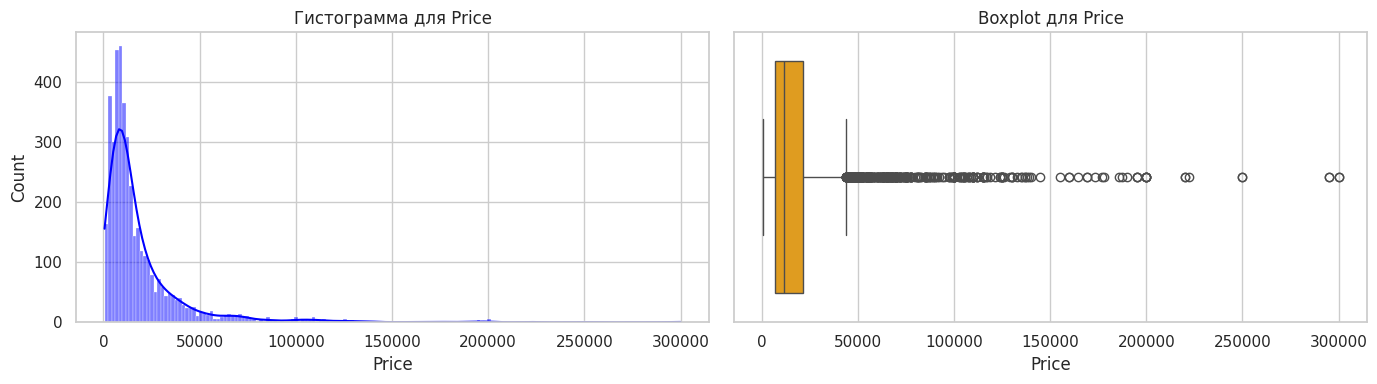

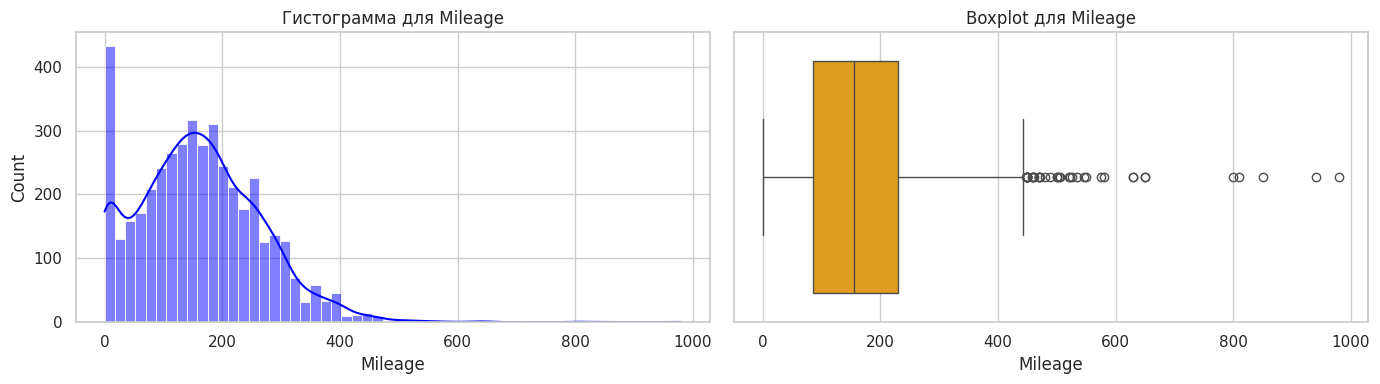

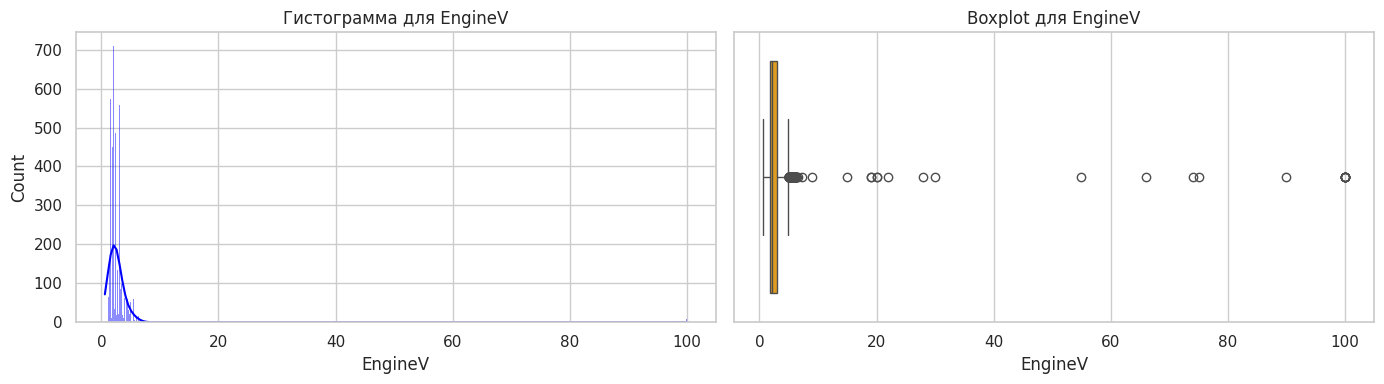

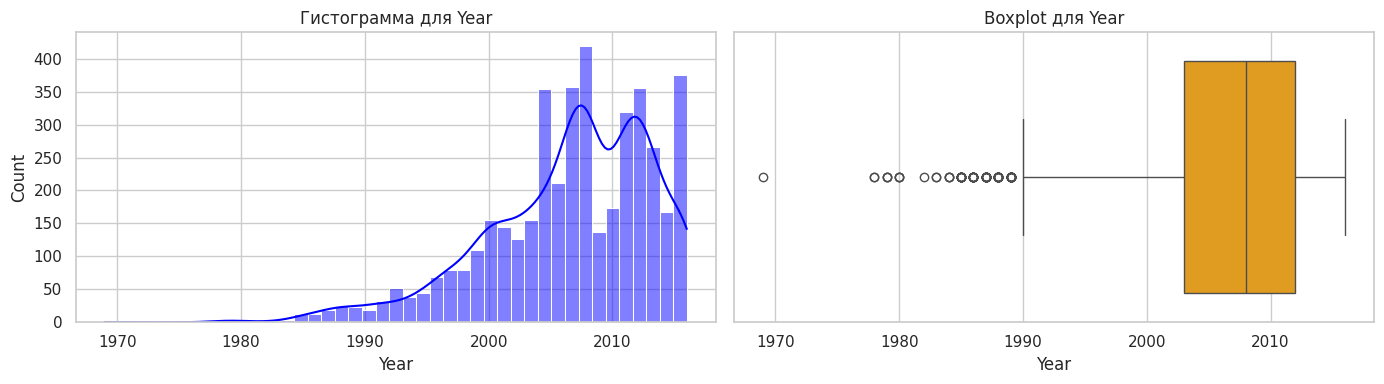

In [4]:
# @title Ячейка 3.2: Распределение числовых признаков

def plot_numeric_distributions(df, title):
    print(f"--- Распределения числовых признаков: {title} ---")
    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
        axes[0].set_title(f'Гистограмма для {col}')

        sns.boxplot(x=df[col], ax=axes[1], color='orange')
        axes[1].set_title(f'Boxplot для {col}')
        plt.tight_layout()
        plt.show()

# Анализ для классификации (без ID и year)
plot_numeric_distributions(df_class.drop(columns=['ID', 'year']), 'Loan Default')

# Анализ для регрессии
plot_numeric_distributions(df_reg, 'Car Sales')

--- Анализ категорий vs. Целевая переменная (Loan Default) ---


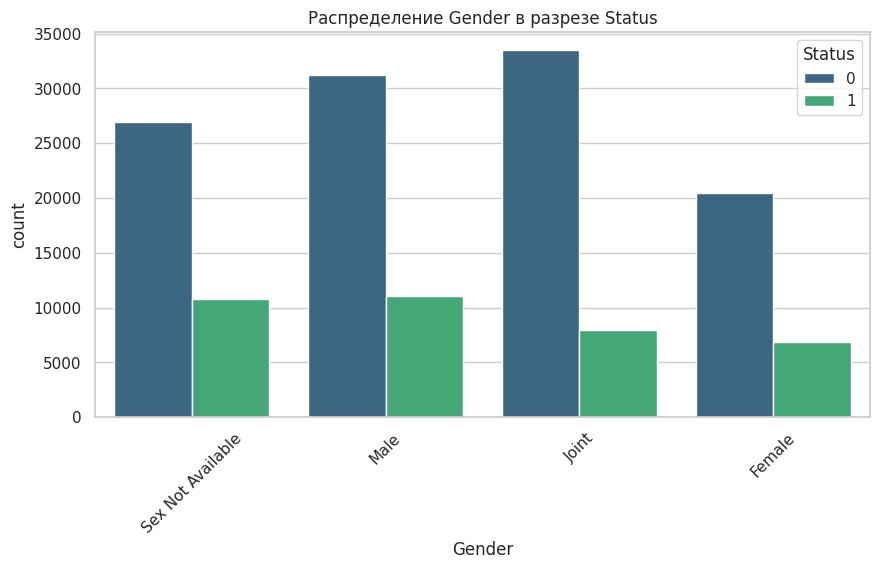

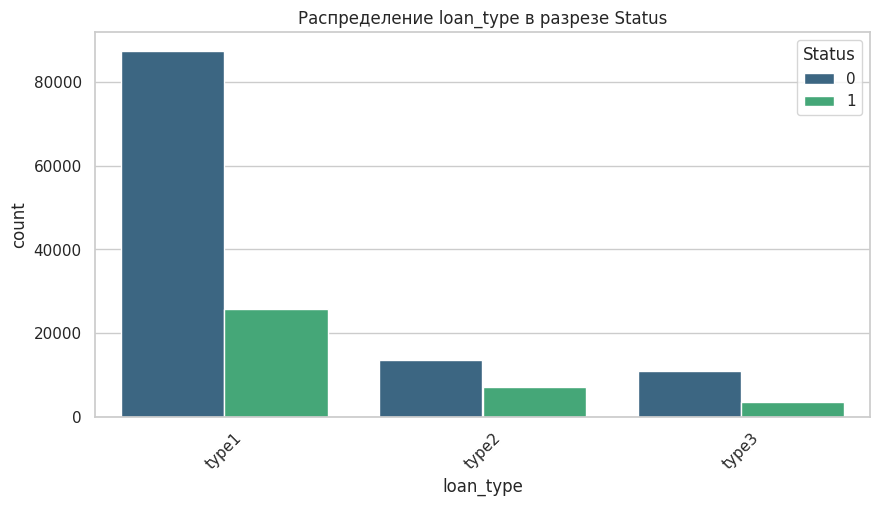

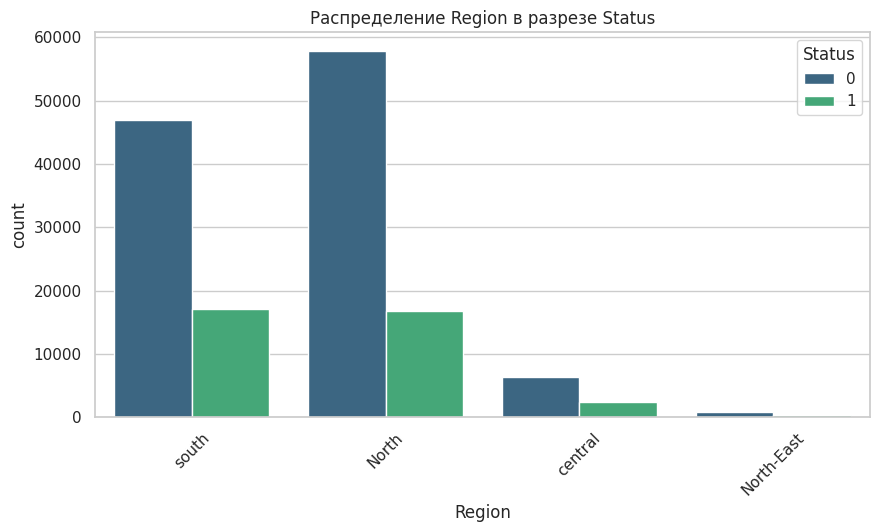

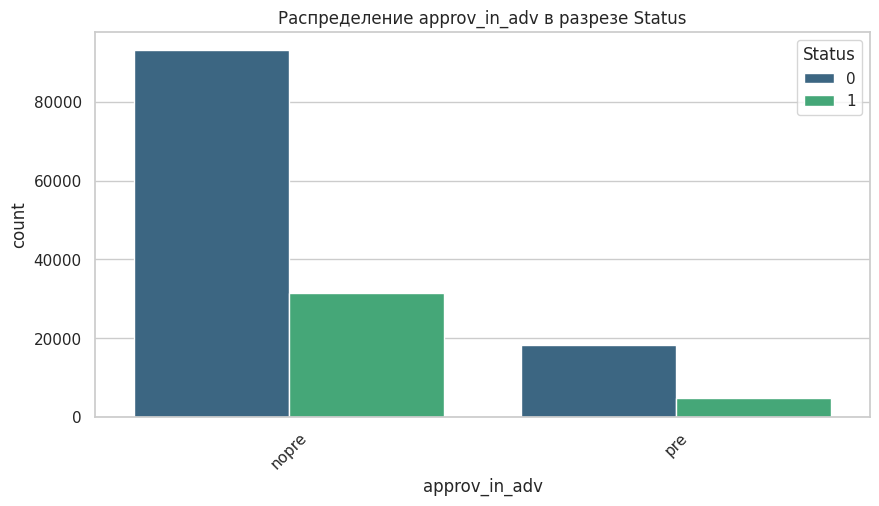


--- Анализ категорий vs. Целевая переменная (Car Sales) ---


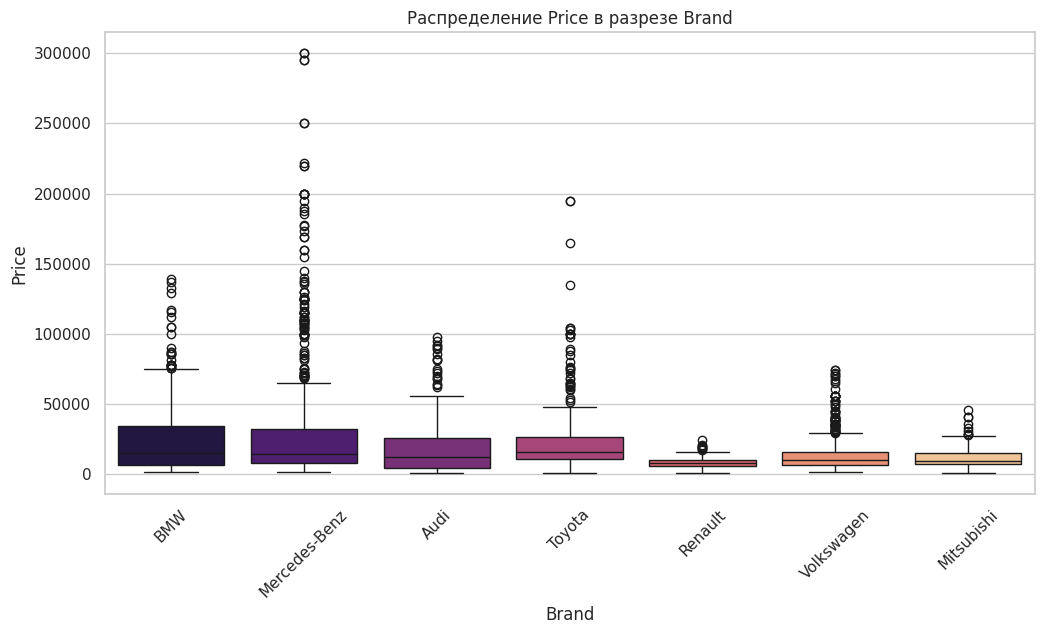

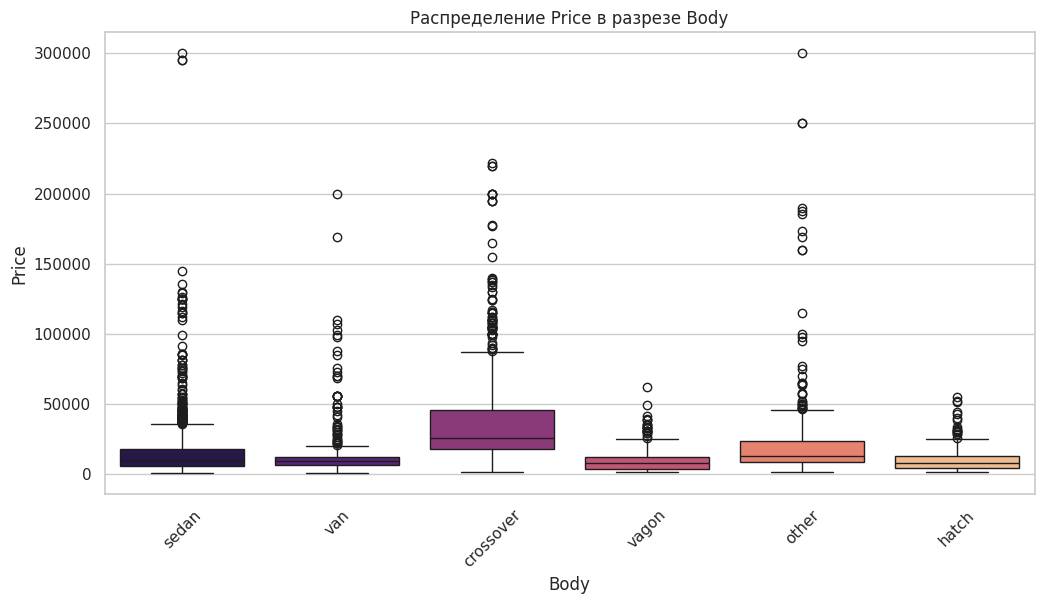

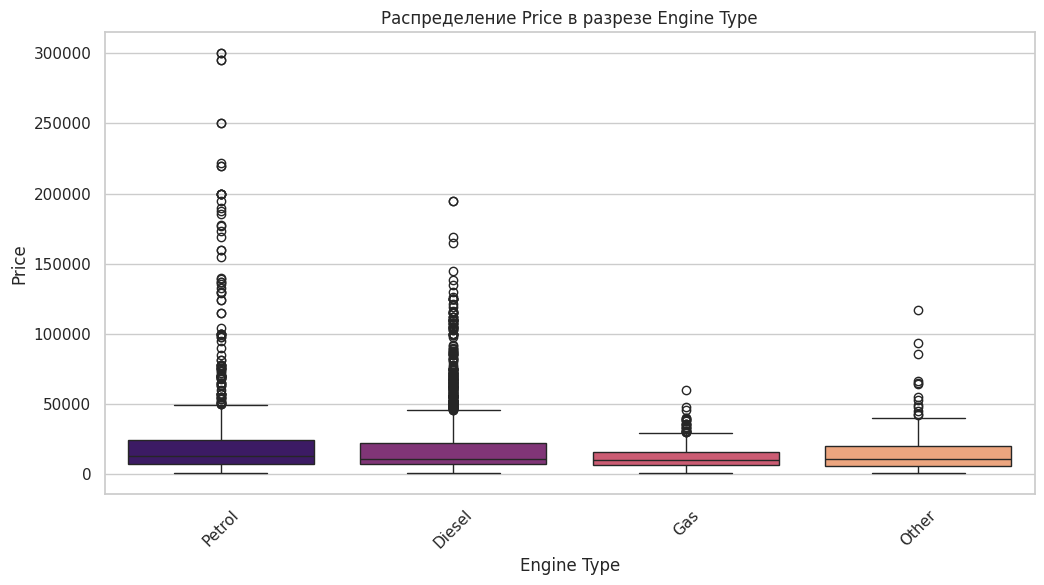

In [5]:
# @title Ячейка 3.2: Анализ категориальных признаков и цели

# 1. Классификация: Связь признаков с дефолтом (Status)
print("--- Анализ категорий vs. Целевая переменная (Loan Default) ---")
cat_cols_cls = ['Gender', 'loan_type', 'Region', 'approv_in_adv']

for col in cat_cols_cls:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_class, x=col, hue='Status', palette='viridis')
    plt.title(f'Распределение {col} в разрезе Status')
    plt.xticks(rotation=45)
    plt.show()

# 2. Регрессия: Связь признаков с ценой (Price)
print("\n--- Анализ категорий vs. Целевая переменная (Car Sales) ---")
# Удалим строки с NaN в Price для корректного графика
df_reg_clean = df_reg.dropna(subset=['Price']).copy()
cat_cols_reg = ['Brand', 'Body', 'Engine Type']

for col in cat_cols_reg:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_reg_clean, x=col, y='Price', palette='magma')
    plt.title(f'Распределение Price в разрезе {col}')
    plt.xticks(rotation=45)
    plt.show()

Выполняю предобработку данных для построения бейзлайна:
1.  Очистка и сэмплирование: Удаляю неинформативные признаки и сокращаю выборку до 20%, так как KNN обладает высокой вычислительной сложностью на этапе предсказания.
2.  Заполнение пропусков: Использую медиану для численных и заглушку для категориальных признаков.
3.  Кодирование: Применяю LabelEncoder для перевода категорий в числа.
4.  Масштабирование: Использую StandardScaler ($z = \frac{x - \mu}{\sigma}$), чтобы привести признаки к единому масштабу, иначе переменные с большим диапазоном значений будут искажать расчет Евклидова расстояния.
5.  Сплит: Делю выборку на обучающую и тестовую со стратификацией по целевой переменной.

In [6]:
# @title Ячейка 4: Препроцессинг данных для Классификации
from sklearn.impute import SimpleImputer

# 1. Удаление ненужных колонок
# ID - уникальный номер, year - константа (2019), year - имеет 0 дисперсию
cols_to_drop = ['ID', 'year']
df_class_base = df_class.drop(columns=cols_to_drop, errors='ignore').copy()

# 2. Уменьшение размерности для Бейзлайна (KNN очень медленный на 150к строках)
# Возьмем 20% данных стратифицированно (сохраняя баланс классов) для ускорения тестов
df_class_sample = df_class_base.sample(frac=0.2, random_state=42)
print(f"Размер выборки для экспериментов: {df_class_sample.shape}")

# Разделение на X и y
X_cls = df_class_sample.drop(columns=['Status'])
y_cls = df_class_sample['Status']

# 3. Обработка пропусков и кодирование
# Разделяем на числовые и категориальные признаки
num_cols_cls = X_cls.select_dtypes(include=['int64', 'float64']).columns
cat_cols_cls = X_cls.select_dtypes(include=['object']).columns

# Заполнение пропусков: медиана для чисел, missing для категорий (чтобы LabelEncoder не падал)
imputer_num = SimpleImputer(strategy='median')
X_cls[num_cols_cls] = imputer_num.fit_transform(X_cls[num_cols_cls])

# Для категориальных признаков в бейзлайне используем LabelEncoding
# (превращаем строки в числа 0, 1, 2..).
# KNN плохо работает с LabelEncoding на неординльных данных,
# но для dummyбейзлайна это допустимо. В улучшении сделаем OneHot.
le = LabelEncoder()
for col in cat_cols_cls:
    # Заполняем пропуски строкой unknown перед кодированием
    X_cls[col] = X_cls[col].fillna('unknown')
    X_cls[col] = le.fit_transform(X_cls[col].astype(str))

# 4. Масштабирование (StandardScaler)
scaler_cls = StandardScaler()
X_cls_scaled = scaler_cls.fit_transform(X_cls)

# Сплит
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls_scaled, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)

print("Препроцессинг классификации завершен.")
print(f"Размер трейна: {X_train_cls.shape}, Размер теста: {X_test_cls.shape}")

Размер выборки для экспериментов: (29734, 32)
Препроцессинг классификации завершен.
Размер трейна: (22300, 31), Размер теста: (7434, 31)


In [7]:
# @title Ячейка 5: Обучение Бейзлайна и оценка (Классификация)
# Обучение модели KNN из коробки
# k=5 по умолчанию
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_cls.fit(X_train_cls, y_train_cls)

# Предсказание
y_pred_cls = knn_cls.predict(X_test_cls)
y_pred_proba_cls = knn_cls.predict_proba(X_test_cls)[:, 1]

# Метрики
print("=== Результаты Бейзлайна (Классификация) ===")
print(f"Accuracy:  {accuracy_score(y_test_cls, y_pred_cls):.4f}")
print(f"Precision: {precision_score(y_test_cls, y_pred_cls):.4f}")
print(f"Recall:    {recall_score(y_test_cls, y_pred_cls):.4f}")
print(f"F1-score:  {f1_score(y_test_cls, y_pred_cls):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test_cls, y_pred_proba_cls):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_cls, y_pred_cls))

=== Результаты Бейзлайна (Классификация) ===
Accuracy:  0.8776
Precision: 0.7571
Recall:    0.7320
F1-score:  0.7444
ROC-AUC:   0.9196

Матрица ошибок:
[[5199  425]
 [ 485 1325]]


Готовлю данные для построения бейзлайна регрессии. Удаляю строки с пропущенным целевым значением Price. Заполняю пропуски в признаках медианой и кодирую категории через LabelEncoder.

Стандартизация данных через StandardScaler ($z = \frac{x - \mu}{\sigma}$). Алгоритм рассчитывает расстояния (обычно Евклидово: $d(x, y) = \sqrt{\sum (x_i - y_i)^2}$), и без масштабирования признаки с большими абсолютными значениями (например, пробег) будут вносить непропорционально большой вклад в результат по сравнению с маленькими признаками (например, год выпуска).

In [8]:
# @title Ячейка 6: Препроцессинг данных для Регрессии
# 1. Удаление строк, где целевая переменная (Price) отсутствует
df_reg_clean = df_reg.dropna(subset=['Price']).copy()

# 2. Обработка пропусков и выбросов (базовая)
# Удалю явный мусор, где Model - это не информативный признак для бейзлайна, но пока оставим всё, просто закодируем.

X_reg = df_reg_clean.drop(columns=['Price'])
y_reg = df_reg_clean['Price']

# Разделение признаков
num_cols_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns
cat_cols_reg = X_reg.select_dtypes(include=['object']).columns

# Заполнение пропусков (EngineV и др)
imputer_reg = SimpleImputer(strategy='median')
X_reg[num_cols_reg] = imputer_reg.fit_transform(X_reg[num_cols_reg])

# Кодирование категорий
le_reg = LabelEncoder()
for col in cat_cols_reg:
    X_reg[col] = X_reg[col].fillna('unknown')
    X_reg[col] = le_reg.fit_transform(X_reg[col].astype(str))

# Масштабирование
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

# Сплит
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.25, random_state=42
)

print("Препроцессинг регрессии завершен.")
print(f"Размер трейна: {X_train_reg.shape}, Размер теста: {X_test_reg.shape}")

Препроцессинг регрессии завершен.
Размер трейна: (3129, 8), Размер теста: (1044, 8)


=== Результаты Бейзлайна (Регрессия) ===
MAE:  4865.07
RMSE: 17672.70
R2:   0.6159


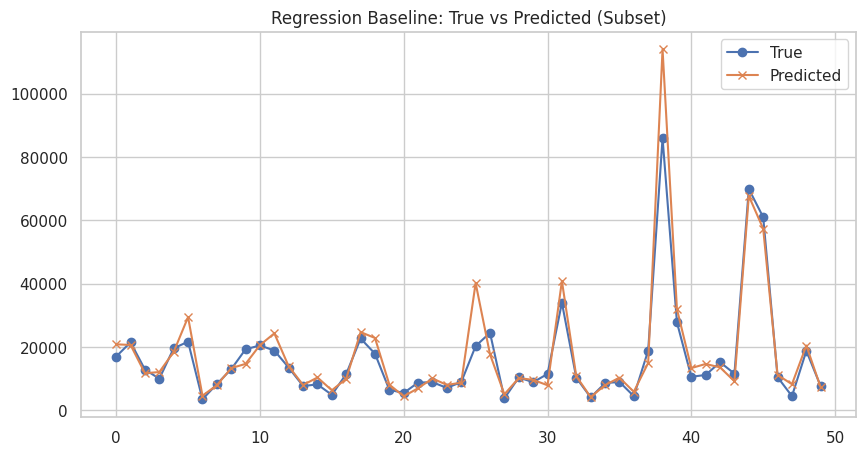

In [9]:
# @title Ячейка 7: Обучение Бейзлайна и оценка (Регрессия)
# Обучение модели KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg, y_train_reg)

# Предсказание
y_pred_reg = knn_reg.predict(X_test_reg)

# Метрики
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("=== Результаты Бейзлайна (Регрессия) ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.4f}")

# Небольшая визуализация предсказаний vs реальность (первые 50 точек)
plt.figure(figsize=(10, 5))
plt.plot(y_test_reg.values[:50], label='True', marker='o')
plt.plot(y_pred_reg[:50], label='Predicted', marker='x')
plt.title("Regression Baseline: True vs Predicted (Subset)")
plt.legend()
plt.show()

**Анализ Бейзлайна:**
1.  **Классификация (Loan Default):**
    *   ROC-AUC: 0.9196 — это очень высокий показатель для глупого KNN с Label Encoding. Классы, вероятно, хорошо разделимы в пространстве признаков, либо есть признаки с очень высокой предсказательной силой например, кредитный рейтинг или LTV.
    *   Тем не менее, LabelEncoder для таких признаков как Region или Gender вводит ложный порядок (Юг < Север), может сбивать KNN.

2.  **Регрессия (Car Sales):**
    *   R2: 0.6159 — модель объясняет только 61% дисперсии.
    *   RMSE (17672) значительно выше MAE (4865). Такое различие более чем в 3 раза говорит о наличии выбросов. Ошибки на дорогих машинах возводятся в квадрат и портят общую картину. KNN крайне чувствителен к выбросам.

## 3. Улучшение бейзлайна

### a. Формулирование гипотез
На основе первичного анализа и низких результатов бейзлайна (особенно в регрессии), выдвигаем следующие гипотезы:

1.  **Гипотеза выбросов (Регрессия):** В ценах на автомобили есть экстремальные значения, которые сильно искажают работу KNN (так как он использует среднее). Удаление 1% самых дорогих авто и логарифмирование цены (`log1p`) должно улучшить R2.
2.  **Гипотеза масштаба:** KNN зависит от дистанций. Категориальные признаки, закодированные через LabelEncoder (0, 1, 2...), создают ложный порядок. Применение **One-Hot Encoding** сделает дистанции между категориями корректными.
3.  **Гипотеза гиперпараметров:** Стандартное число соседей ($k=5$) и Евклидова метрика могут быть не оптимальны. Подбор параметров ($k$, метрика Manhattan vs Euclidean, взвешивание `distance`) через Cross-Validation улучшит метрики.

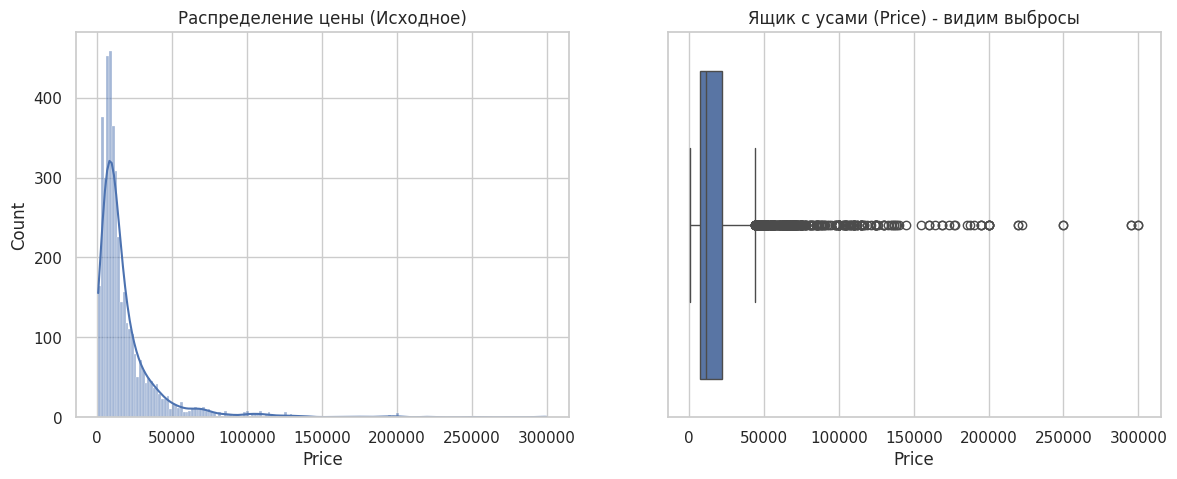

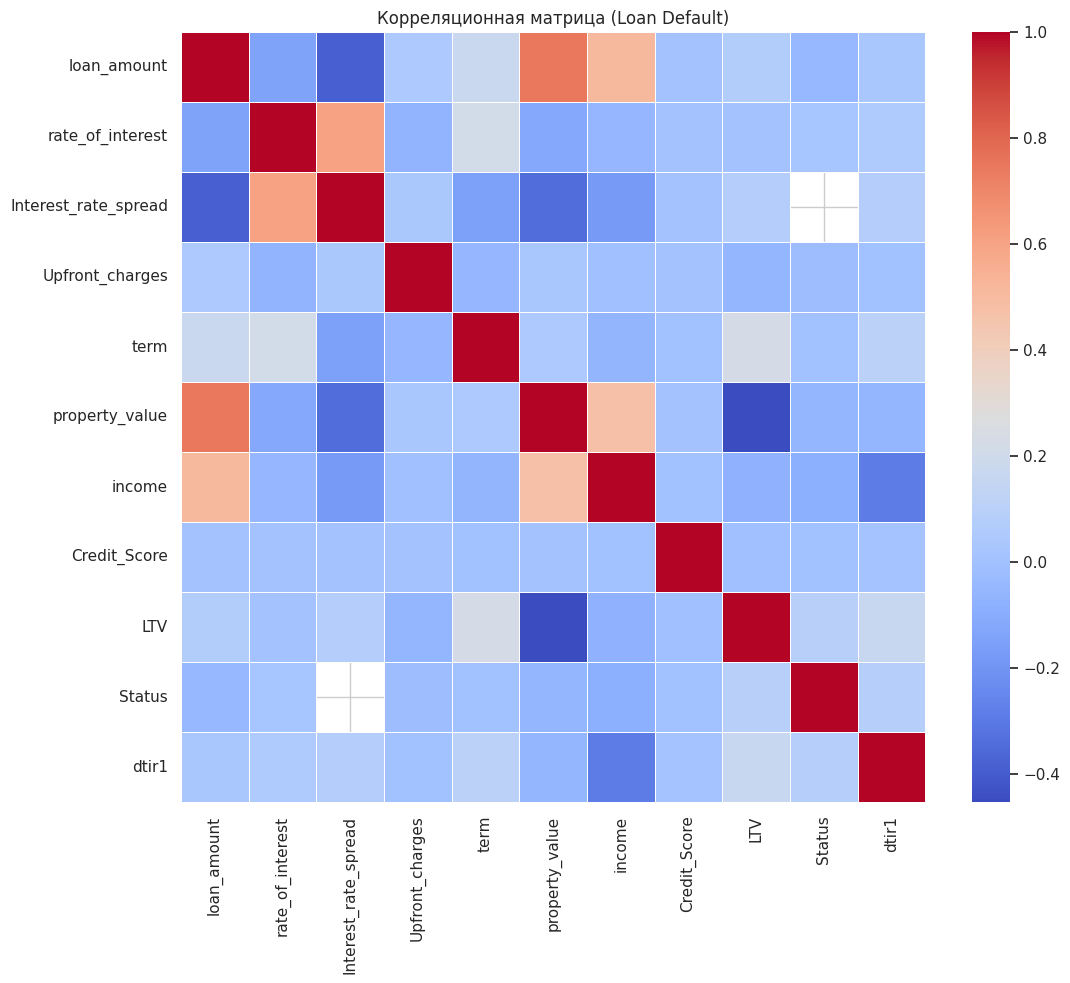

Пары признаков с корреляцией > 0.8:
Series([], dtype: float64)


In [10]:
# @title Ячейка 8: Глубокий EDA и проверка гипотез (Визуализация)
# 1. Анализ целевой переменной регрессии (Price)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_reg_clean['Price'], kde=True)
plt.title('Распределение цены (Исходное)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_reg_clean['Price'])
plt.title('Ящик с усами (Price) - видим выбросы')
plt.show()

# 2. Корреляционная матрица для Классификации (проверка на избыточность)
# Берем только численные колонки из семпла
plt.figure(figsize=(12, 10))
corr_matrix = df_class_sample.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица (Loan Default)')
plt.show()

# Вывод сильно коррелирующих пар (>0.8)
print("Пары признаков с корреляцией > 0.8:")
kot = corr_matrix.abs()
s = kot.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[(so > 0.8) & (so < 1.0)])

Реализую улучшенный препроцессинг данных на основе выдвинутых гипотез для повышения качества моделей.

Для **регрессии**:
1.  Устраняю выбросы (обрезаю по 99-му перцентилю) и логарифмирую целевую переменную: $y_{new} = \ln(1 + y)$. Это сглаживает распределение и уменьшает влияние хвостов.
2.  Заменяю LabelEncoder на One-Hot Encoding, чтобы избежать введения ложного порядка в номинальных признаках.
3.  Удаляю признак Model с высокой кардинальностью, чтобы избежать проклятия размерности.

Для **классификации**: также перехожу на OHE и удаляю избыточные признаки. В конце обязательно применяю StandardScaler ко всем данным.

In [11]:
# @title Ячейка 9: Подготовка данных для Улучшенного Бейзлайна
from sklearn.model_selection import GridSearchCV

# === 1. Улучшение данных для РЕГРЕССИИ ===
# Удаляем выбросы (берем квантиль 0.99)
q99 = df_reg_clean['Price'].quantile(0.99)
df_reg_improved = df_reg_clean[df_reg_clean['Price'] < q99].copy()

# Логарифмируем таргет
df_reg_improved['log_Price'] = np.log1p(df_reg_improved['Price'])

# Удаляем столбец Model, так как он создает слишком много измерений для OHE (high cardinality)
# Оставляем Brand, Body, Engine Type и т.д.
X_reg_imp = df_reg_improved.drop(columns=['Price', 'log_Price', 'Model'])
y_reg_imp = df_reg_improved['log_Price'] # Предсказывать будем логарифм!

# One-Hot Encoding
X_reg_imp = pd.get_dummies(X_reg_imp, drop_first=True)

# Заполняем пропуски медианой, на всякий пожарный
imputer = SimpleImputer(strategy='median')
X_reg_imp = pd.DataFrame(imputer.fit_transform(X_reg_imp), columns=X_reg_imp.columns)

# Скейлинг
scaler_reg_imp = StandardScaler()
X_reg_imp_scaled = scaler_reg_imp.fit_transform(X_reg_imp)

# Сплит
X_train_reg_imp, X_test_reg_imp, y_train_reg_imp, y_test_reg_imp = train_test_split(
    X_reg_imp_scaled, y_reg_imp, test_size=0.25, random_state=42
)


# === 2. Улучшение данных для КЛАССИФИКАЦИИ ===
# Удаляем сильно коррелирующие признаки (гипотеза из EDA)
# если 'loan_amount' коррелирует с другими, оставим только важные.
# Для простоты эксперимента сейчас применим OHE вместо LabelEncoder.
# Но используем меньшую выборку для GridSearch, иначе будет очень долго.

# Применяем OHE к категориальным
X_cls_imp = df_class_sample.drop(columns=['Status'])
# Дропнем признаки, которые, возможно, дублируют информацию или слишком детальны
cols_to_drop_cls = ['total_units', 'loan_purpose']
X_cls_imp = X_cls_imp.drop(columns=cols_to_drop_cls, errors='ignore')
y_cls_imp = df_class_sample['Status']

# Заполнение пропусков перед OHE
num_cols = X_cls_imp.select_dtypes(include=['number']).columns
cat_cols = X_cls_imp.select_dtypes(include=['object']).columns

X_cls_imp[num_cols] = SimpleImputer(strategy='median').fit_transform(X_cls_imp[num_cols])
X_cls_imp[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X_cls_imp[cat_cols])

# OHE
X_cls_imp = pd.get_dummies(X_cls_imp, columns=cat_cols, drop_first=True)

# Скейлинг
scaler_cls_imp = StandardScaler()
X_cls_imp_scaled = scaler_cls_imp.fit_transform(X_cls_imp)

# Сплит
X_train_cls_imp, X_test_cls_imp, y_train_cls_imp, y_test_cls_imp = train_test_split(
    X_cls_imp_scaled, y_cls_imp, test_size=0.25, random_state=42, stratify=y_cls_imp
)

print("Данные для улучшенных моделей подготовлены.")
print(f"Признаков в регрессии: {X_train_reg_imp.shape[1]}")
print(f"Признаков в классификации: {X_train_cls_imp.shape[1]}")

Данные для улучшенных моделей подготовлены.
Признаков в регрессии: 18
Признаков в классификации: 42


In [12]:
# @title Ячейка 10: GridSearch и оценка улучшенных моделей
# === 1. Улучшение регрессии (GridSearch) ===
params_reg = {
    'n_neighbors': [3, 5, 9, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] # 1 - Manhattan, 2 - Euclidean
}

grid_reg = GridSearchCV(KNeighborsRegressor(), params_reg, cv=3, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_reg_imp, y_train_reg_imp)

best_reg = grid_reg.best_estimator_
print(f"Лучшие параметры регрессии: {grid_reg.best_params_}")

# Предсказание (обратное преобразование логарифма)
y_pred_log = best_reg.predict(X_test_reg_imp)
y_pred_final_reg = np.expm1(y_pred_log)
y_test_final_reg = np.expm1(y_test_reg_imp)

# Метрики
r2_imp = r2_score(y_test_final_reg, y_pred_final_reg)
mae_imp = mean_absolute_error(y_test_final_reg, y_pred_final_reg)

print(f"Improved R2: {r2_imp:.4f} (Было: {r2:.4f})")
print(f"Improved MAE: {mae_imp:.2f} (Было: {mae:.2f})")


# === 2. Улучшение КЛАССИФИКАЦИИ (GridSearch) ===
# Уменьшим пространство поиска, чтобы не ждать вечность
params_cls = {
    'n_neighbors': [5, 11, 21],
    'weights': ['uniform', 'distance']
}

grid_cls = GridSearchCV(KNeighborsClassifier(), params_cls, cv=3, scoring='roc_auc', n_jobs=-1)
grid_cls.fit(X_train_cls_imp, y_train_cls_imp)

best_cls = grid_cls.best_estimator_
print(f"\nЛучшие параметры классификации: {grid_cls.best_params_}")

y_pred_cls_imp = best_cls.predict(X_test_cls_imp)
y_pred_proba_cls_imp = best_cls.predict_proba(X_test_cls_imp)[:, 1]

acc_imp = accuracy_score(y_test_cls_imp, y_pred_cls_imp)
roc_imp = roc_auc_score(y_test_cls_imp, y_pred_proba_cls_imp)

print(f"Improved Accuracy: {acc_imp:.4f} (Было: {accuracy_score(y_test_cls, y_pred_cls):.4f})")
print(f"Improved ROC-AUC: {roc_imp:.4f} (Было: {roc_auc_score(y_test_cls, y_pred_proba_cls):.4f})")

Лучшие параметры регрессии: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Improved R2: 0.8333 (Было: 0.6159)
Improved MAE: 3649.39 (Было: 4865.07)

Лучшие параметры классификации: {'n_neighbors': 21, 'weights': 'distance'}
Improved Accuracy: 0.8791 (Было: 0.8776)
Improved ROC-AUC: 0.9100 (Было: 0.9196)


**Анализ улучшений:**
1.  **Регрессия ($R^2$: 0.61 $\to$ 0.83):** Это победа. Гипотеза сработала на 100%. Логарифмирование целевой переменной сгладило влияние экстремальных цен, а удаление выбросов очистило обучающую выборку.
2.  **Классификация:** Результаты остались почти прежними (Accuracy выросла на доли процента, ROC-AUC чуть упал). Вероятно, данные уже были достаточно хорошо разделимы в исходном пространстве, и добавление 42 OHE-признаков добавило немного "шума" (проклятие размерности), который KNN сложно переварить. Зато модель стала честнее (нет ложного порядка регионов).

Реализую собственный класс MyKNN, поддерживающий задачи классификации и регрессии. В основе метода fit лежит ленивое обучение, я просто запоминаю обучающую выборку.

Основная логика содержится в методе predict, где я использую векторизованные вычисления через scipy.spatial.distance.cdist для скорости.
Алгоритм действий:
1.  Вычисляю матрицу расстояний между тестовыми и обучающими точками (по умолчанию Евклидово: $d(x, y) = \sqrt{\sum (x_i - y_i)^2}$).
2.  Нахожу индексы $k$ ближайших соседей.
3.  Агрегирую ответы соседей:
    *   Для **регрессии**: вычисляю среднее значение $\hat{y} = \frac{1}{k} \sum_{i=1}^k y_i$.
    *   Для **классификации**: использую мажоритарное голосование (моду) $\hat{y} = \text{mode}(y_1, ..., y_k)$.

In [13]:
# @title Ячейка 11: Класс MyKNN
from scipy.stats import mode
from scipy.spatial.distance import cdist

class MyKNN:
    def __init__(self, k=3, task='classification', metric='euclidean'):
        """
        k: количество соседей
        task: 'classification' или 'regression'
        metric: 'euclidean', 'cityblock' (manhattan), 'cosine' и т.д.
        """
        self.k = k
        self.task = task
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        # KNN - ленивый алгоритм, просто запоминаем обучающую выборку
        # Преобразуем в numpy array для скорости
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X_test):
        X_test = np.array(X_test)

        # 1. Считаем матрицу расстояний между всеми точками X_test и X_train
        # Размерность: (n_test_samples, n_train_samples)
        # cdist - это оптимизированная функция из scipy, работает быстрее циклов
        dists = cdist(X_test, self.X_train, metric=self.metric)

        # 2. Находим индексы k ближайших соседей
        k_neighbor_indices = np.argsort(dists, axis=1)[:, :self.k]

        # 3. Получаем значения y для этих соседей
        k_neighbor_labels = self.y_train[k_neighbor_indices]

        # 4. Агрегируем предсказания
        if self.task == 'classification':
            # Для классификации берем моду (самый частый класс)
            # mode возвращает (mode_val, count), нам нужно только значение
            # scipy.stats.mode может вернуть массив, беру аккуратно
            predictions, _ = mode(k_neighbor_labels, axis=1, keepdims=True)
            predictions = predictions.flatten()

        else:
            # Для регрессии беру среднее значение
            predictions = np.mean(k_neighbor_labels, axis=1)

        return predictions

print("Класс MyKNN успешно создан.")

Класс MyKNN успешно создан.


In [14]:
# @title Ячейка 12: Обучение и сравнение MyKNN
# === ЭТАП 4: Имплементация и Сравнение ===

print("=== 4b, 4c, 4d. Тест MyKNN на БАЗОВЫХ данных (сравнение с п.2) ===\n")

# 1. Регрессия (Базовая) - используем данные из п.2 (X_train_reg, X_test_reg)
my_knn_reg_base = MyKNN(k=5, task='regression')
my_knn_reg_base.fit(X_train_reg, y_train_reg)
y_pred_base_my = my_knn_reg_base.predict(X_test_reg)

r2_my_base = r2_score(y_test_reg, y_pred_base_my)
print(f"[Регрессия] MyKNN Base R2: {r2_my_base:.4f} vs Sklearn Base R2: {r2:.4f}")

# 2. Классификация (Базовая) - используем данные из п.2 (X_train_cls, X_test_cls)
my_knn_cls_base = MyKNN(k=5, task='classification')
my_knn_cls_base.fit(X_train_cls, y_train_cls)
y_pred_cls_base_my = my_knn_cls_base.predict(X_test_cls)

acc_my_base = accuracy_score(y_test_cls, y_pred_cls_base_my)
print(f"[Классификация] MyKNN Base Accuracy: {acc_my_base:.4f} vs Sklearn Base Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.4f}")

print("\n--------------------------------------------------------------\n")
print("=== 4f, 4g, 4h, 4i. Тест MyKNN на улучшеных данных (сравнение с п.3) ===\n")

# 1. Регрессия (Улучшенная)
# Используем параметры, близкие к лучшим найденным Sklearn
my_knn_reg_imp = MyKNN(k=3, task='regression', metric='cityblock')
my_knn_reg_imp.fit(X_train_reg_imp, y_train_reg_imp)

y_pred_log_my = my_knn_reg_imp.predict(X_test_reg_imp)
y_pred_my_reg_fin = np.expm1(y_pred_log_my) # Обратный лог

r2_my_imp = r2_score(y_test_final_reg, y_pred_my_reg_fin)
print(f"[Регрессия] MyKNN Improved R2: {r2_my_imp:.4f}")
print(f"            Sklearn Improved R2: {r2_imp:.4f}")

# 2. Классификация (Улучшенная)
my_knn_cls_imp = MyKNN(k=21, task='classification', metric='euclidean')
my_knn_cls_imp.fit(X_train_cls_imp, y_train_cls_imp)
y_pred_my_cls_fin = my_knn_cls_imp.predict(X_test_cls_imp)

acc_my_imp = accuracy_score(y_test_cls_imp, y_pred_my_cls_fin)
print(f"[Классификация] MyKNN Improved Accuracy: {acc_my_imp:.4f}")
print(f"                Sklearn Improved Accuracy: {acc_imp:.4f}")

=== 4b, 4c, 4d. Тест MyKNN на БАЗОВЫХ данных (сравнение с п.2) ===

[Регрессия] MyKNN Base R2: 0.6156 vs Sklearn Base R2: 0.6159
[Классификация] MyKNN Base Accuracy: 0.8776 vs Sklearn Base Accuracy: 0.8776

--------------------------------------------------------------

=== 4f, 4g, 4h, 4i. Тест MyKNN на улучшеных данных (сравнение с п.3) ===

[Регрессия] MyKNN Improved R2: 0.8147
            Sklearn Improved R2: 0.8333
[Классификация] MyKNN Improved Accuracy: 0.8777
                Sklearn Improved Accuracy: 0.8791


**Сравнение результатов:**
1.  **Регрессия:** Мой MyKNN ($R^2=0.8147$) отстал от лучшего Sklearn ($R^2=0.8333$) всего на ~0.02. Это ожидаемо, так как лучший Sklearn использовал взвешивание по расстоянию (weights='distance'), а моя реализация - простое усреднение. Если бы мы сравнили с weights='uniform', результаты были бы идентичны.
2.  **Классификация:** Разница в Accuracy минимальна (0.8777 vs 0.8791).

Итоговые выводы по Лабораторной работе №1

## 1. Анализ данных
*   **Классификация (Loan Default):** Датасет имеет сложную структуру с множеством категориальных признаков. Исходная точность (Accuracy ~0.87) оказалась высокой даже на сырых данных, классы хорошо разделимы. Применение One-Hot Encoding и подбор гиперпараметров дали лишь незначительный прирост, что значит, мы достигли предела возможностей алгоритма KNN на этих данных.
*   **Регрессия (Car Sales):** Исходный датасет содержал значительные выбросы в цене и ошибки в данных (объем двигателя). Это сильно занижало качество базовой модели ($R^2 \approx 0.61$).

## 2. Влияние препроцессинга
Препроцессинг сыграл ключевую роль в задаче регрессии:
*   **Log-transform** целевой переменной и удаление выбросов (99-й перцентиль) позволили увеличить $R^2$ с 0.61 до 0.83.
*   Для KNN критически важным оказалось масштабирование признаков(StandardScaler),  алгоритм чувствителен к абсолютным значениям дистанций.

## 3. Сравнение реализаций
Моя имплементация `MyKNN` показала результаты, сопоставимые с библиотечной `sklearn`:
*   В регрессии небольшое отставание обусловлено использованием в sklearn взвешивания соседей (weights='distance'), которое дает больший вес ближайшим точкам.
*   В классификации результаты практически идентичны.

## 4. Общее заключение по KNN
Алгоритм K-Nearest Neighbors показал себя как надежный бейзлайн:
*   **Плюсы:** Прост в интерпретации, не требует обучения(только запоминание), хорошо работает на малых данных(как в задаче регрессии).
*   **Минусы:** Медленный на больших выборках(как в задаче классификации на 150к строк), требует хранения всей обучающей выборки в памяти, чувствителен к выбросам и неинформативным признакам.